In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA

from statsmodels.stats.weightstats import _tconfint_generic


from tqdm import tqdm_notebook
from IPython import display

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\LD dataset features'
beginning_of_name_EL = '\Feature matrix EL'
beginning_of_name_EL_OM = '\Feature matrix EL+OM'
end_of_name = ' 5 peaks.csv'

data_el = pd.read_csv(path + beginning_of_name_EL + end_of_name, index_col=0)
data_el.drop(['Label for OM and EL'], axis=1, inplace=True)
data_el = data_el[data_el['SNR'] >= 5]
data_el = data_el[data_el['target'] != -1]


X = data_el.drop('target', axis=1)
y = data_el['target'].astype('int')
print(X.shape)


data_om = pd.read_csv(path + beginning_of_name_EL_OM + end_of_name)
data_om.fillna(0, inplace=True)
data_om = data_om[data_om['SNR'] >= 5]
data_om = data_om[data_om['target'] != -1]


X1 = data_om.drop('target', axis=1) 
y1 = data_om['target'].astype('int')
print(X1.shape)

def scaleColumns(df, cols_to_scale):
    scaler = StandardScaler()
    for col in cols_to_scale:
        scaled_features = scaler.fit_transform((df[col]).values.reshape((-1, 1)))
        df[col] = pd.DataFrame(scaled_features,columns=[col], index=df[col].index)
    return df

columns = X.columns
columns = columns.drop(['SNR', 'second_harmonics'])
X = scaleColumns(X, columns)

columns1 = X1.columns
columns1 = columns1.drop(['SNR_opt', 'SNR', 'second_harmonics_opt', 'second_harmonics' ])

X1 = scaleColumns(X1, columns1)

(1252, 24)
(1252, 48)


In [3]:
data_om.rename(columns=lambda x: x.replace('.1', '_opt'), inplace=True)
data_om.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
path = r'C:\Users\ecath\Desktop\Research\Raw Data\LD dataset features'

data_om.to_csv(path + beginning_of_name_EL_OM + end_of_name, sep=',', index=False)

0.0    1143
1.0     109
Name: target, dtype: int64


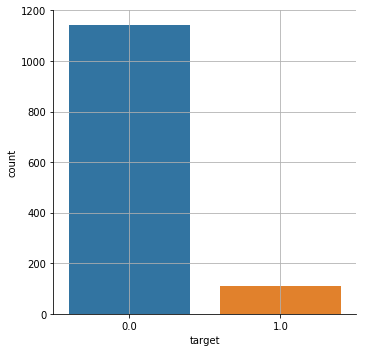

In [4]:
print(data_el['target'].value_counts())
sns.factorplot('target', data = data_el, kind="count")
plt.grid()
plt.show()

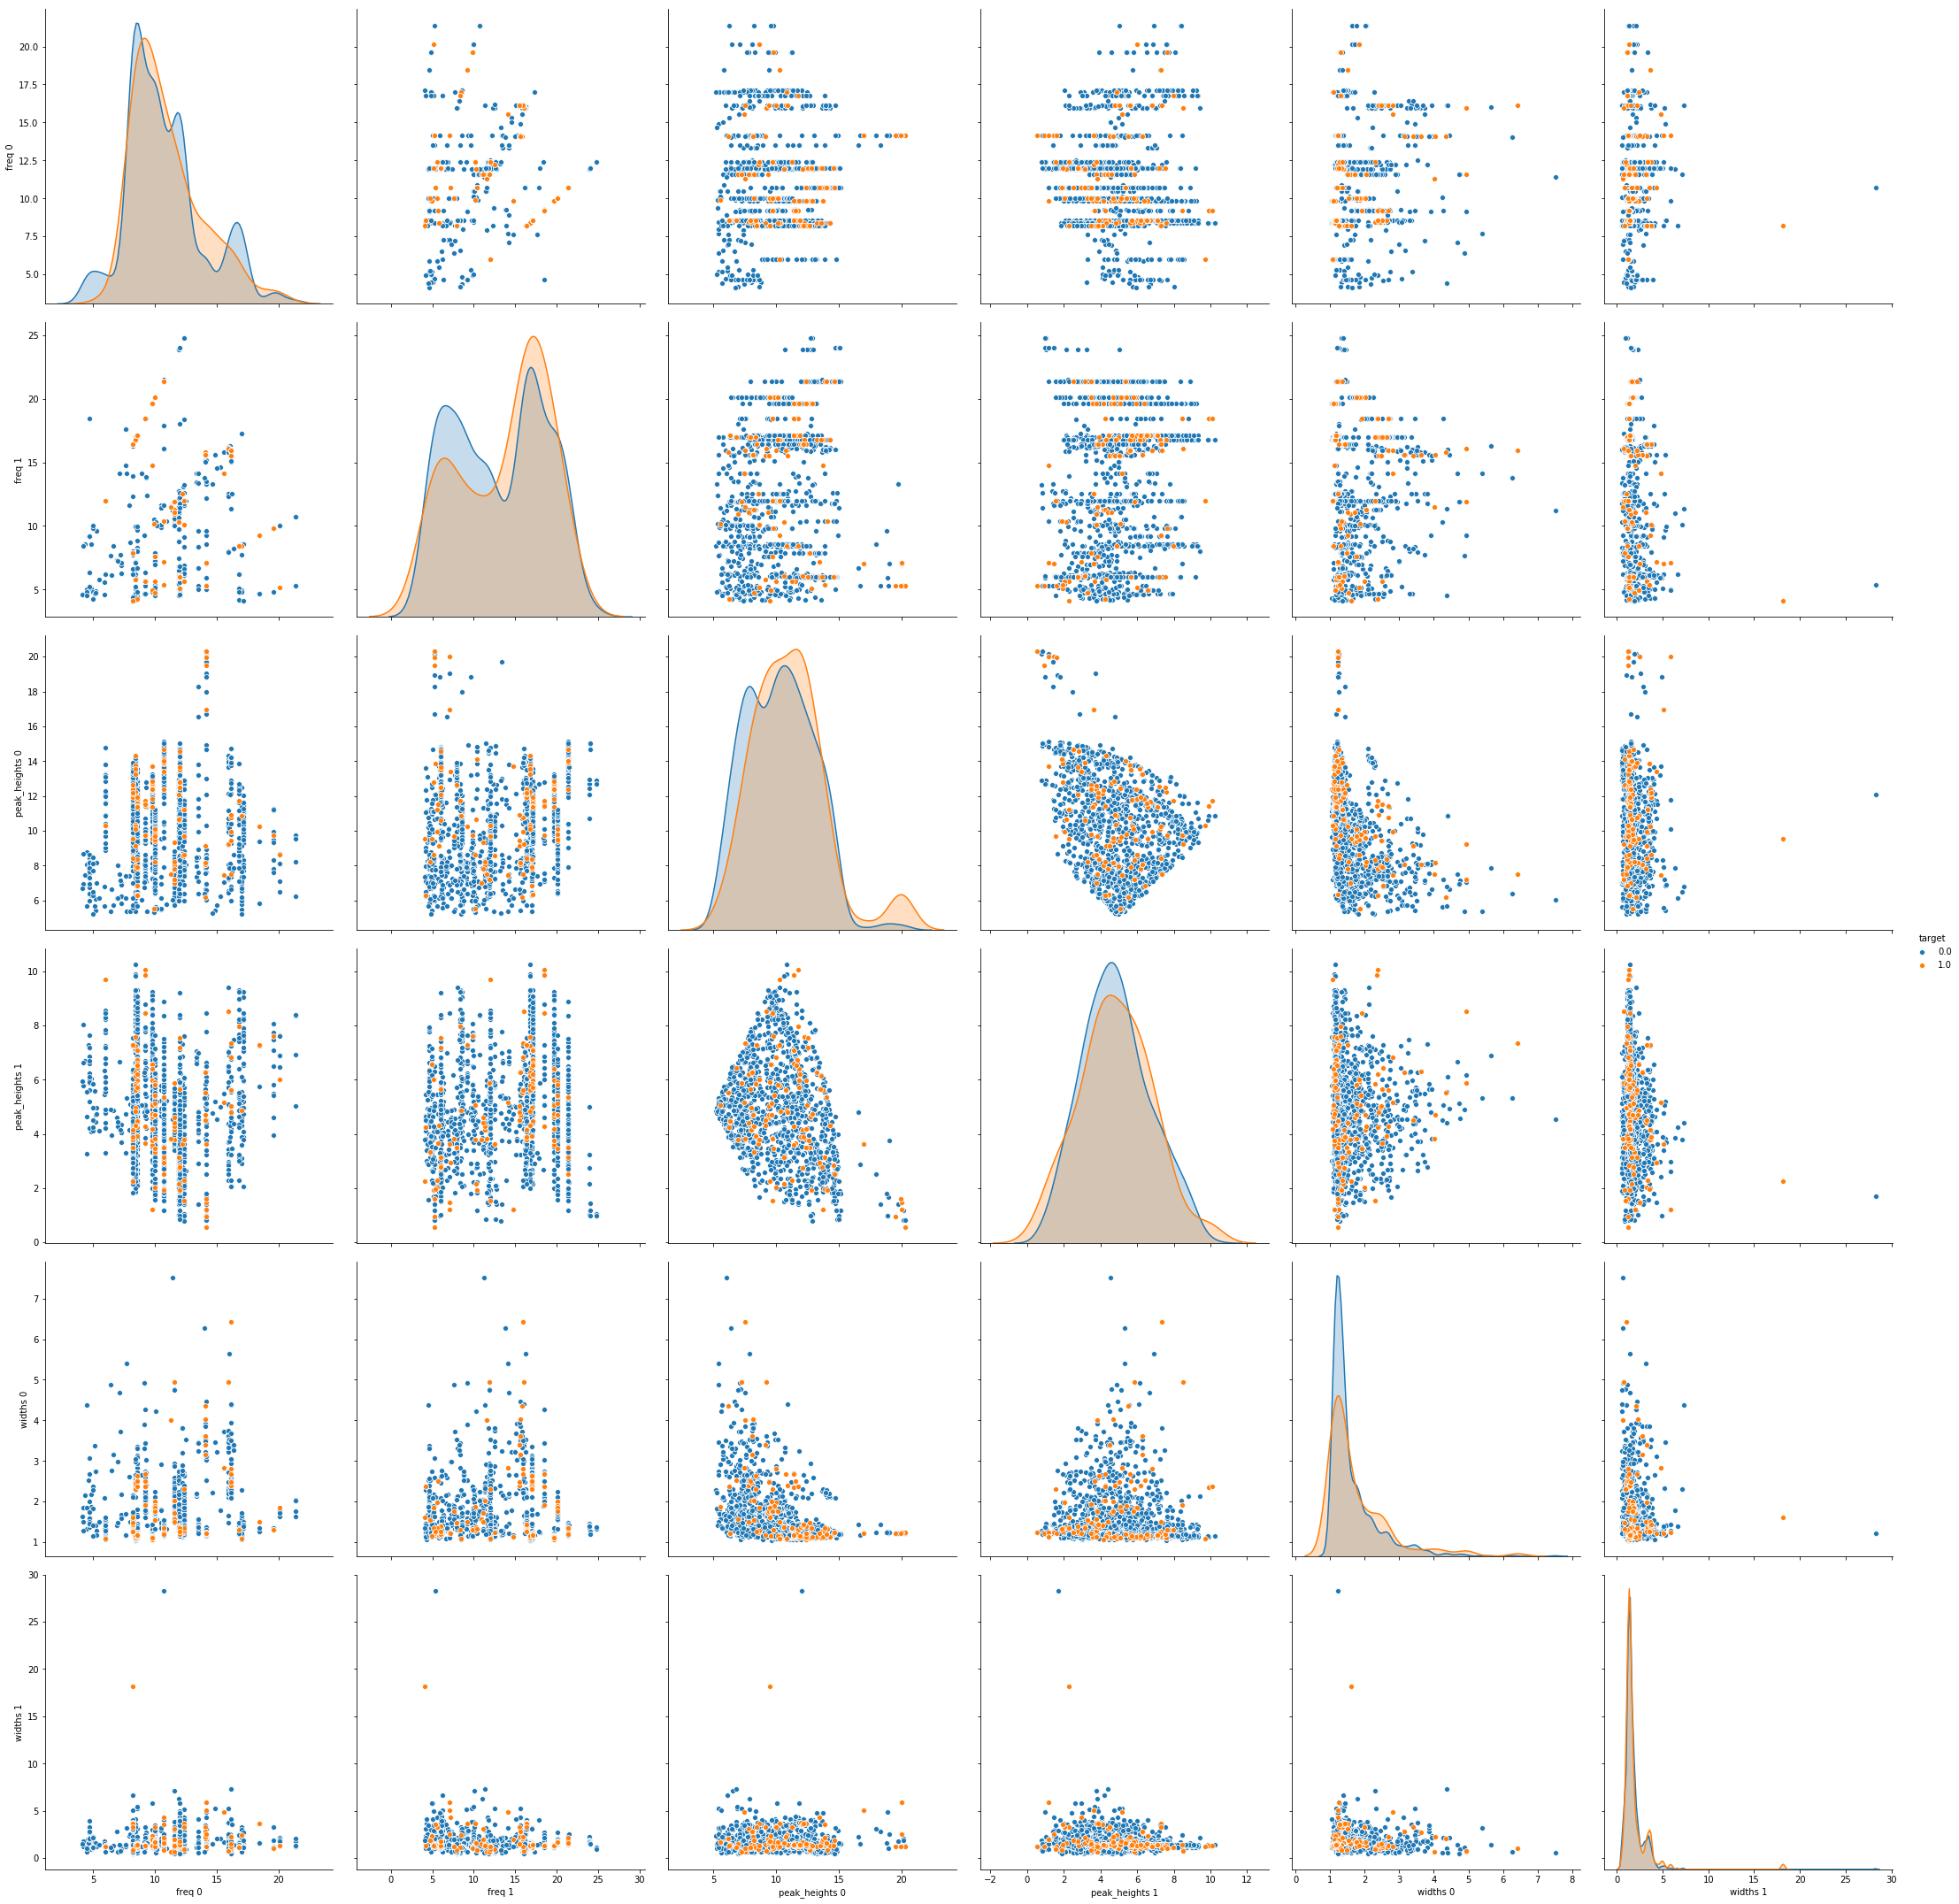

In [5]:
sns.pairplot(data_el, hue='target', 
             vars=['freq 0', 'freq 1',
                   'peak_heights 0', 'peak_heights 1', 
                   'widths 0', 'widths 1'],  height=5)

plt.savefig(r'C:\Users\ecath\Desktop\Research\corr_plot.png', format='png')

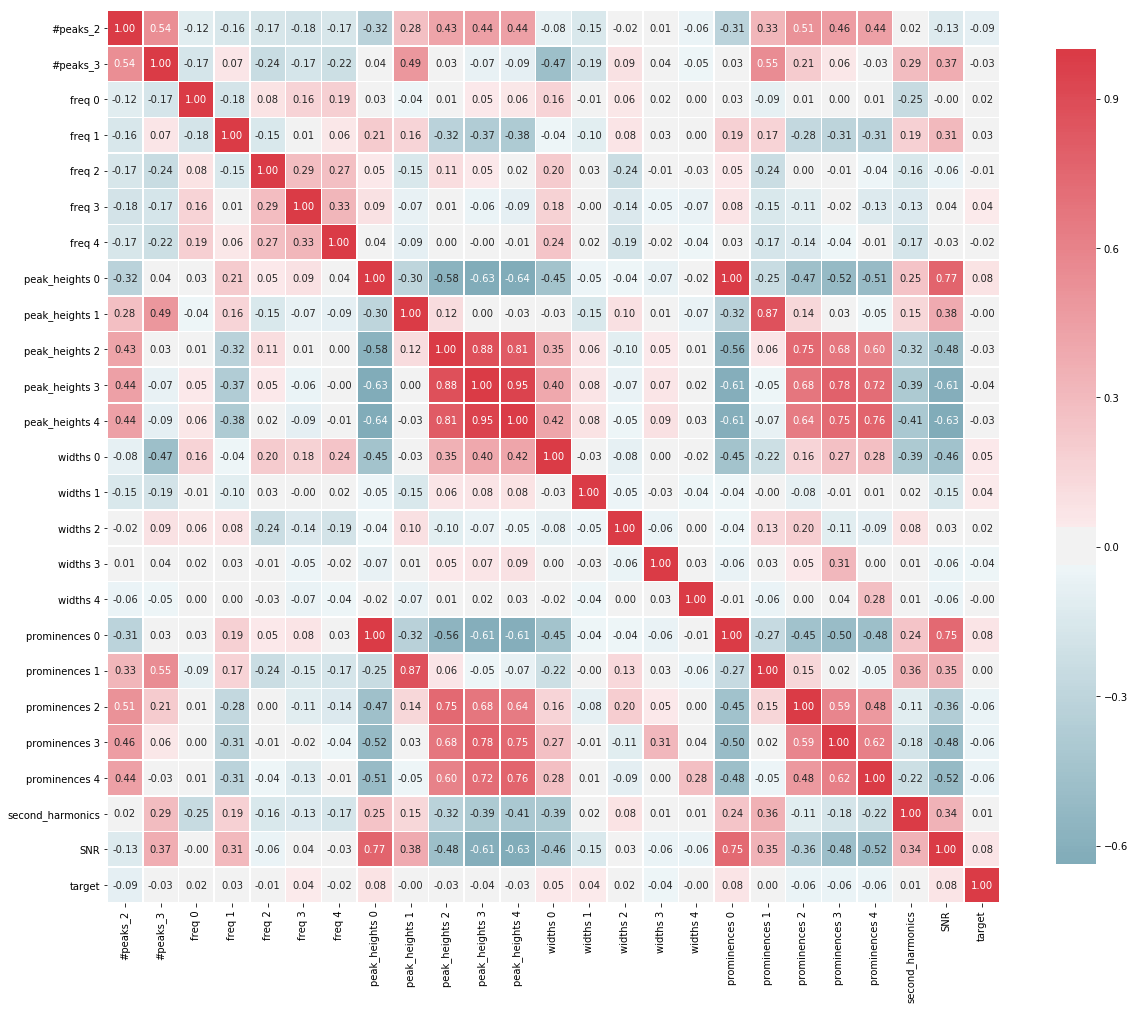

In [6]:
corr = data_el.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, 
            linewidths=.5, annot=True, cbar_kws={"shrink": .75})
plt.savefig(r'C:\Users\ecath\Desktop\Research\coor_heatmap.png', format='png')

[44.8 58.5 65.2 69.1 72.2 75.1 77.3 79.4 81.3 83.2 84.8 86.3 87.8 89.1
 90.3 91.3 92.2 92.9 93.6 94.3 94.9 95.4 95.9 96.4 96.8]


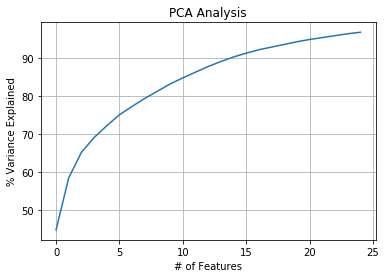

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
X_pca = pca.fit_transform(X1) 
# print(pca.explained_variance_ratio_)
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)
print(variance)
# print(pca.components_)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')

plt.plot(variance)
plt.grid()

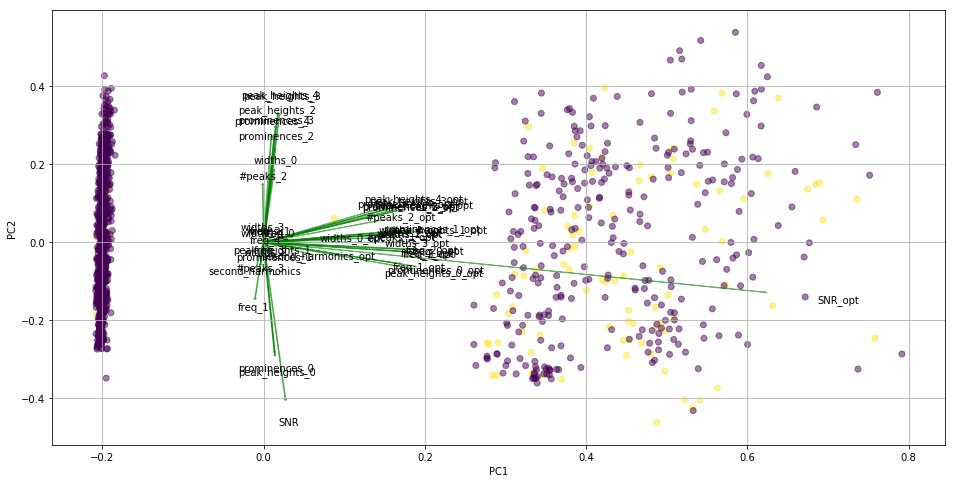

In [8]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y1, alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'g',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, X1.columns[i],  ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], ha = 'center', va = 'center')

plt.figure(figsize=(16,8))

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
#Call the function. Use only the 2 PCs.
myplot(X_pca[:,0:2], np.transpose(pca.components_[0:2, :]))
# plt.savefig(r'C:\Users\ecath\Desktop\Research\PCA MEM NIOM 1.png', format='png')
plt.show()

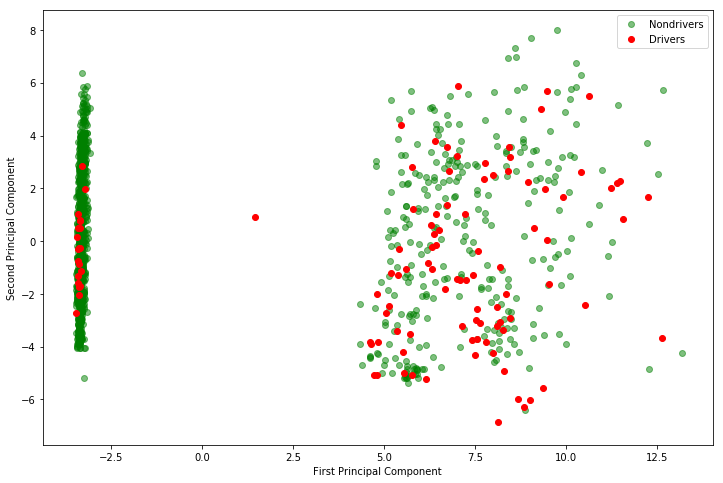

In [9]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]

labels=y
cdict={1:'red',0:'green', -1:'blue'}
labl={0:'Nondrivers',1:'Drivers', -1:'Noise'}
alpha={0:.5, 1:1, -1:0.5}
fig,ax=plt.subplots(figsize=(12,8))
fig.patch.set_facecolor('white')

for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],
           label=labl[l], alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.savefig(r'C:\Users\ecath\Desktop\Research\PCA MEM.png', format='png')
plt.show()

In [11]:
f1 = np.zeros((1,2)) 
acc = np.zeros((1,2))
roc_auc = np.zeros((1,2))
precision = np.zeros((1,2))
recall = np.zeros((1,2))
matrix = np.zeros((3,2))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, stratify=y)

  
parameters = {
#               'n_estimators': np.arange(10, 100, 10),
#         'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 11)]
#     'n_estimators': np.arange(410, 460, 5),
#             'max_depth': [int(x) for x in np.arange(10, 100, 10)]
#                   'criterion':['gini', 'entropy']
             }


clf = RandomForestClassifier(class_weight='balanced', 
                             random_state=42, min_samples_split=11, 
                             min_samples_leaf=6, bootstrap=False, n_estimators=420)   
clf1 = RandomForestClassifier(class_weight='balanced', 
                              random_state=42, min_samples_split=11, 
                              min_samples_leaf=6, bootstrap=False, n_estimators=460)   


optimizer = GridSearchCV(clf, parameters, cv=10, scoring='f1')
optimizer1 = GridSearchCV(clf1, parameters, cv=10, scoring='f1')

optimizer.fit(X_train, y_train) 
print(optimizer.param_grid, optimizer.best_score_, optimizer.best_params_)

y_pred = optimizer.best_estimator_.predict(X_test)

optimizer1.fit(X1_train, y1_train) 
print(optimizer1.best_score_, optimizer1.best_params_)
y1_pred = optimizer1.best_estimator_.predict(X1_test)



f1[0][0]= f1_score(y_test, y_pred)
f1[0][1]= f1_score(y1_test, y1_pred)

acc[0][0]= balanced_accuracy_score(y_test, y_pred)
acc[0][1]= balanced_accuracy_score(y1_test, y1_pred)

roc_auc[0][0] = roc_auc_score(y_test, y_pred)
roc_auc[0][1] = roc_auc_score(y1_test, y1_pred)

precision[0][0] = precision_score(y_test, y_pred)
precision[0][1] = precision_score(y1_test, y1_pred)

recall[0][0] = recall_score(y_test, y_pred)
recall[0][1] = recall_score(y1_test, y1_pred)


{} 0.1159380953901502 {}
0.2741305490701139 {}


In [16]:
print(' F1 score = ', f1,'\n', 'Accuracy = ', acc)

 F1 score =  [[0.24489796 0.39344262]] 
 Accuracy =  [[0.57633183 0.65849457]]


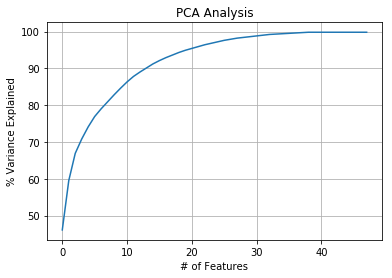

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X1_test) 
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')

plt.plot(variance)
plt.grid()

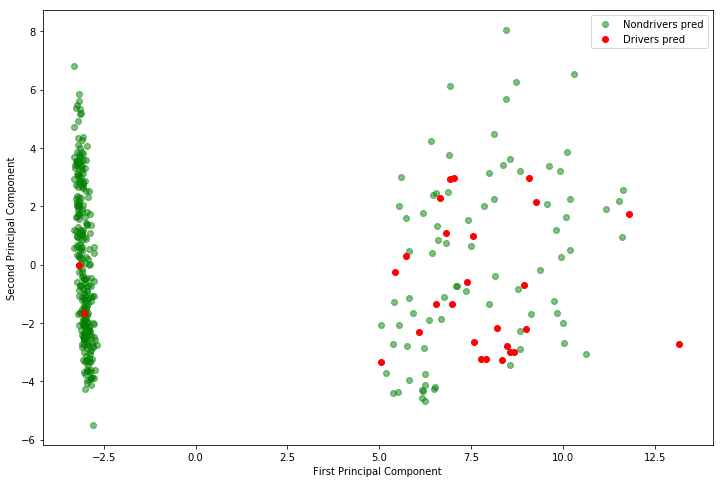

In [14]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]

labels=y1_pred
cdict={1:'red',0:'green', -1:'blue'}
labl={0:'Nondrivers pred',1:'Drivers pred', -1:'Noise'}
alpha={0:.5, 1:1, -1:0.5}
fig,ax=plt.subplots(figsize=(12,8))
fig.patch.set_facecolor('white')

for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],
           label=labl[l], alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()

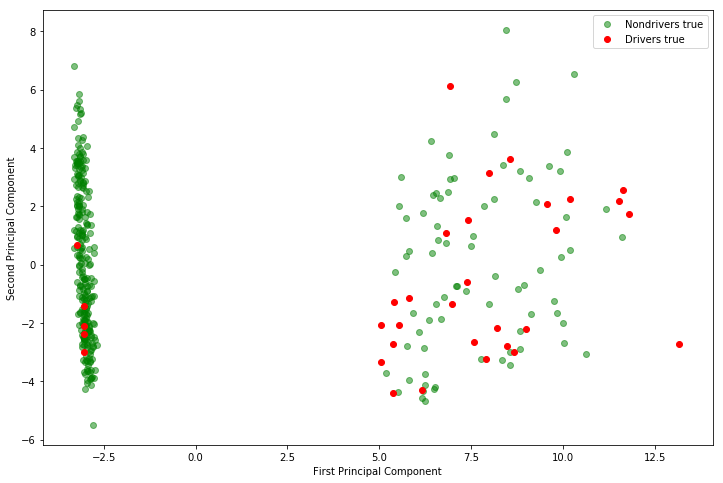

In [15]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]

labels=y1_test
cdict={1:'red',0:'green', -1:'blue'}
labl={0:'Nondrivers true',1:'Drivers true', -1:'Noise'}
alpha={0:.5, 1:1, -1:0.5}
fig,ax=plt.subplots(figsize=(12,8))
fig.patch.set_facecolor('white')

for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],
           label=labl[l], alpha=alpha[l])

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()
